# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [ ]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
from torch import optim
from torch.optim import lr_scheduler
import torch.utils.data
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision.models as models
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# Import other modules if required                  f"Test accuracy: {accuracy/len(testloader):.3f}")
import os
import sys
import xml.etree.ElementTree as ET
from PIL import Image
import imageio
from scipy.misc import imresize
from pathlib import Path
import copy
import time
from IPython.display import clear_output as clr
import tarfile
from sklearn.utils import class_weight as cw
from sklearn.metrics import precision_score as pscr
from google.colab import files
import cv2
# Can use other libraries as well

resnet_input = 224#size of resnet18 input images

In [ ]:
# Choose your hyper-parameters using validation data
batch_size = 100
num_epochs = 5
learning_rate =  0.001
hyp_momentum = 0.9

#### Downloading and Extracting Files

In [3]:
### uncomment to download and extract folders...................
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar 
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar 
traintar = tarfile.open("VOCtrainval_06-Nov-2007.tar")
traintar.extractall("./train_data")
traintar = tarfile.open("VOCtest_06-Nov-2007.tar")
traintar.extractall("./test_data")

--2019-03-28 08:40:04--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  14.1MB/s    in 36s     

2019-03-28 08:40:40 (12.3 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2019-03-28 08:40:42--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

#### Colors for bounding boxes

In [ ]:
COLORS = np.array([[255,0,0],[0,255,0],[0,0,255]]).astype('float')

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [ ]:
trainval_path = "train_data/VOCdevkit/VOC2007"
test_path = "test_data/VOCdevkit/VOC2007"
anno = '/Annotations'
imgs = '/ImageSets'
jpeg = '/JPEGImages'
segc = '/SegmentationClass'
sego = '/SegmentationObject'
save = "/classes"
try:
    os.stat(trainval_path + save)
except:
    os.mkdir(trainval_path + save)
    
try:
    os.stat(test_path + save)
except:
    os.mkdir(test_path + save)

In [ ]:
classes = ('__background__',
           'aeroplane',
           'bottle',
           'chair'
           )

class_labels = {
    '__background__' : 0,
    'aeroplane' : 1,
    'bottle' : 2,
    'chair' : 3,
}

#### Iou Computation function

In [ ]:
def compute_iou(box_pred,box_true, skewed = False):
  
  xx1 = max(box_pred[2], box_true[2])
  yy1 = max(box_pred[0], box_true[0])
  xx2 = min(box_pred[3], box_true[3])
  yy2 = min(box_pred[1], box_true[1])

  # compute the width and height of the bounding box
  w = max(0, xx2 - xx1 + 1)
  h = max(0, yy2 - yy1 + 1)
  
  area_true = (box_true[3] - box_true[2] + 1) * (box_true[1] - box_true[0] + 1)
  area_pred = (box_pred[3] - box_pred[2] + 1) * (box_pred[1] - box_pred[0] + 1)

  # compute the ratio of overlap between the computed
  # bounding box and the bounding box in the area list
  if(skewed):
    iou = float(w * h) / (max(area_true, area_pred) - w*h)
  else:    
    iou = float(w * h) / (area_true + area_pred - w*h)

  return iou

### Build dataset loader


Note : For Background we have formed a bounding box conatining all the bounding boxes inside and sampled background outside this bigger bouding box ensiuring the iou is 0.

In [ ]:
def build_dataset(path):
    # Begin
    count = np.zeros((len(classes)))
    
    ## part 1 Image class based cropping and resizing
    for xml_path in os.listdir(path + anno):
        ### Parsing the tree........
        tree = ET.parse(path + anno + "/" + xml_path)
        image = Image.open(path + jpeg + "/" + tree.getroot()[1].text)
        image_arr = np.array(image)
        y0 = 0
        x0 = 0
        y1 = image_arr.shape[0]
        x1 = image_arr.shape[1]
        
        xout = 0
        xin  = 10000
        yout = 0
        yin  = 10000
        img_n_obj = 0
        
        # Looking for class names. .....
        for obj in tree.getroot().findall('object'):
            class_name = obj[0].text
            if(class_name in classes):
                img_n_obj+=1
                xmin = int(obj[4][0].text)
                ymin = int(obj[4][1].text)
                xmax = int(obj[4][2].text)
                ymax = int(obj[4][3].text)
                
                ### Creating a bigger bounding box which contain all bounding boxes
                xout = max(xout, xmax)
                xin  = min(xin,  xmin)
                yout = max(yout, ymax)
                yin  = min(yin,  ymin)
                
                subimg = np.array(
                    Image.fromarray(
                        np.array(image)[ymin:ymax,xmin:xmax]
                    ).resize((resnet_input,resnet_input)))
                label = class_labels[class_name]
                try:
                    os.stat(path + save+"/"+str(label))
                except:
                    os.mkdir(path + save+"/"+str(label))
                subpath = path+save+"/"+str(label)+'/'+str(int(count[label]))+'.jpg'
                imageio.imwrite(subpath, subimg)
                count[label] += 1
           
        
        ## part 2 Image hard negative mining for negative class (Background Images)
        ##  The backgrounds are sampled from areas outside the bigger bounding box
        r1 = image_arr[yout:y1, :]
        r2 = image_arr[y0:yin, :]
        r3 = image_arr[: , x0:xin]
        r4 = image_arr[: , xout:x1]
        
        p1 = y1-yout
        p2 = yin-y0
        p3 = xin-x0
        p4 = x1-xout
        
        pvec = np.array([p1,p2,p3,p4])
        pvec = pvec/np.sum(pvec)
        
        bcount = 0
        infcount = 0
        
        # Sampling classes + 3 extra background images from current image....
        while (bcount < (img_n_obj//3 + 3) and infcount < 100):
            infcount += 1
            try:
              
                # Trying to get a background randomly ..............
                bcount += 1
                img = np.random.choice([r1,r2,r3,r4], p = pvec)

                a0 = np.random.randint(0,img.shape[1])
                a1 = min(np.random.randint(a0,img.shape[1])+50,img.shape[1])
                b0 = np.random.randint(0,img.shape[0])
                b1 = min(np.random.randint(b0,img.shape[1])+50,img.shape[0])
                

                back_img = np.array(
                        Image.fromarray(
                            img[b0:b1, a0:a1]
                        ).resize((resnet_input,resnet_input)))

                label = class_labels["__background__"]
                try:
                    os.stat(path + save+"/"+str(label))
                except:
                    os.mkdir(path + save+"/"+str(label))
                back_path = path+save+"/"+str(label)+'/'+str(int(count[label]))+'.jpg'
                imageio.imwrite(back_path, back_img)
                count[label] += 1
            except:
                pass

Run Below cell after uncommenting to build dataset

In [ ]:
### Uncomment to build classification dataset................
build_dataset(trainval_path)
build_dataset(test_path)

In [ ]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.root = os.path.expanduser(root_dir)
        self.transform = transform
        self.train = train
        
        # distortions for better learning..........
        self.train_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.RandomAffine(5, translate=(0.1,0.1)),
#             transforms.RandomRotation(30),
            transforms.RandomCrop(224),
        ])
                                         
        self.images = []
        self.labels = []
        folder_class = self.root + save
        for lbl in os.listdir(folder_class):
            folder_img = folder_class + "/" + lbl
            for img_name in os.listdir(folder_img):
                img_path = folder_img + "/" + img_name
                self.images.append(img_path)
                self.labels.append(int(lbl))
                
        self.random_indices = np.arange(len(self.labels))
        np.random.shuffle(self.random_indices)
        
        
    def __len__(self):
        # Begin
        return len(self.labels)
        
    def __getitem__(self, idx):
       # Begin
        a_idx = self.random_indices[idx]
        img = Image.open(self.images[a_idx]).convert('RGB')
        target = self.labels[a_idx]
        y_onehot = torch.tensor(target)
        
        if self.transform is not None:
          if(self.train):
#             img = self.transform(img)
            img = self.transform(self.train_transform(img))
          else:
            img = self.transform(img)
        
        # Uncomment below lines to introduce noise in the image ... for regularization
        if(train):
#           a,b,c = np.array(img).shape
#           img += torch.tensor(0.001*(np.random.rand(a,b,c) - 0.5)).type(torch.FloatTensor)
          pass
        return img,y_onehot

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [ ]:
composed_transform = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])
train_dataset = voc_dataset(root_dir=trainval_path, train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = voc_dataset(root_dir=test_path, train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


####  Defining dictionary for the dataloaders ....

dataloaders = {
    'train' : train_loader,
    'test' : test_loader
}

#### Calculating the class weights for skewed dataset .......

In [ ]:
class_weights = cw.compute_class_weight('balanced',np.unique(train_dataset.labels), train_dataset.labels)

In [ ]:
c_weights = (torch.tensor(class_weights).float()).cuda()

In [14]:
c_weights

tensor([0.4759, 3.8142, 1.9913, 0.8816], device='cuda:0')

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [ ]:
## Flattening layer.........
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [16]:
device = 'cuda'
torch.device(device)

device(type='cuda')

## One layer Model

In [17]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 256)
model = nn.Sequential(*(list(list(resnet18.children()))[:-1]), 
                              Flatten(),
                              nn.Linear(512,128),
                              nn.ReLU(),
                              nn.Linear(128,4),
                             ).to(device)
# model.load_state_dict(torch.load('modelwts.h5'))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 70787812.09it/s]


In [ ]:
criterion = nn.CrossEntropyLoss(weight=c_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
model.to(device)
print("Done")
# summary(model, (3,224,224)) # uncomment to see model structure.....

Done


In [ ]:
# Train function to be called.....
def train(model, criterion, optimizer, scheduler, num_epochs = 100, filename = 'modelwts.h5'):
    # Begin
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    avg_prec = 0.0
    best_map = 0.0
    
    
    epoch_loss = 1000.0
    epoch_acc = 0.0
    for epoch in range(num_epochs):
        start = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            ## Loss, Acc for model evaluation
            running_loss = 0.0
            running_corrects = 0
            
            count = 0
            lnh = dataloaders[phase].__len__() # length of the dataset
            precs = [] # precision array
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                if(phase == 'train'):
                  clr(wait=True)
                  print('Current Epoch :', epoch, 'remaining :', num_epochs - epoch)
                  print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))
                  print("mAP : ",avg_prec, ', Best Acc :', best_acc)
                  time_elapsed = time.time() - start
                  print('Training complete in {:.0f}m {:.0f}s'.format(
                      time_elapsed // 60, time_elapsed % 60))
                  print(phase + "ing on batch no :", count, "out of", lnh)
                  
                  
                count+=1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pre = pscr(labels.data.cpu().numpy(), preds.cpu().numpy(), labels = [0,1,2,3], average = 'micro')
                precs.append(np.mean(pre))
                if(phase == 'train'):
                    print("Current Loss", loss.item(), "curr_prec", pre)
                    
                

            epoch_loss = running_loss / lnh
            epoch_acc = running_corrects.double() /lnh
            avg_prec = np.mean(precs)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and avg_prec > best_map:
                best_map = avg_prec
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, filename)


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [87]:
%time model = train(model, criterion, optimizer, scheduler, num_epochs = 15, filename = "modelwts.h5") # Uncomment to train model1

Current Epoch : 14 remaining : 1
train Loss: 42.4880 Acc: 88.0816
mAP :  0.8825850340136056 , Best Acc : tensor(88.0816, device='cuda:0', dtype=torch.float64)
Training complete in 1m 6s
training on batch no : 50 out of 51
Current Loss 0.07983758300542831 curr_prec 0.96
train Loss: 5.3543 Acc: 96.0784
test Loss: 42.7394 Acc: 87.7755
CPU times: user 17min 33s, sys: 5min 41s, total: 23min 15s
Wall time: 23min 19s


## Two layer Model...

In [22]:
model_2_layer = nn.Sequential(*(list(list(resnet18.children()))[:-3]), 
                              Flatten(),
                              nn.Linear(50176,64),
                              nn.LeakyReLU(),
                              nn.Linear(64,16),
                              nn.LeakyReLU(),
                              nn.Linear(16,4), 
                             ).to(device)

# model_2_layer.load_state_dict(torch.load('model2wts.h5'))
model_2_layer.to(device)
print("Done")
criterion2 = nn.CrossEntropyLoss(weight=c_weights)
optimizer2 = optim.Adam(model_2_layer.parameters(), lr=learning_rate)
scheduler2 = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# summary(model_2_layer, input_size = (3,224,224)) uncomment to print summary of model......

Done


In [88]:
%time model_2_layer = train(model_2_layer, criterion2, optimizer2, scheduler2, num_epochs = 15, filename = "model2wts.h5") # uncommen to train...model2

Current Epoch : 14 remaining : 1
train Loss: 50.1896 Acc: 84.9184
mAP :  0.8509297052154194 , Best Acc : tensor(88.6735, device='cuda:0', dtype=torch.float64)
Training complete in 0m 58s
training on batch no : 50 out of 51
Current Loss 0.08152918517589569 curr_prec 0.98
train Loss: 3.7571 Acc: 97.1569
test Loss: 48.9968 Acc: 87.8367
CPU times: user 16min 5s, sys: 4min 18s, total: 20min 24s
Wall time: 20min 23s




# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

#### Sliding Window function

In [ ]:
def sliding_window(img, two_layer = False, th1 = 0.98, th2 = 0.98):
    # Begin
#   th = 0.98
      
  img = np.array(img)
  Nn,Nm,Cn = img.shape  
  ratio_x = Nn/500
  ratio_y = Nm/500
  
  # Initializing the kernel list will contain all the windows of different scales adn strides...
  kernels = []
  
  # Stride for image based on image size
  stride = [int(40*ratio_x),int(40*ratio_y)]
  
  ## Creating the window sizes at different scales and aspect ratios...
  for i in [100,150,250]:
    for j in [0.7, 1.0, 1.3, 1.7, 2.0]:
      kernels.append([int(i*ratio_x),int(i*j*ratio_y),stride[0],stride[1]])
      kernels.append([int(i*j*ratio_x),int(i*ratio_y),stride[1],stride[0]])
      kernels.append([int(i*j*ratio_x),int(i*j*ratio_y),stride[1],stride[0]])
      
      
  
  ### Initializing the accepted bounding boxes and coreresponding probabilities as null....
  
  bboxes = {
    1 : [],
    2 : [],
    3 : []
  }
  
  prs = {
      1 : [],
      2 : [],
      3 : []
  }
  
  
  # Set of boxes and image patches....
  images = []
  pboxes = []

  
  ## Iterating over kernels
  for kernel in kernels:
    D1, D2, C = img.shape
    N = int(np.ceil((D1-kernel[0])/(kernel[2]) + 1))
    M = int(np.ceil((D2-kernel[1])/(kernel[3]) + 1))

    # Iterating over each patch ...
    for i in range(N):
      for j in range(M):
        
        # Finding the coordinates of patch
        v_u = i*kernel[2]
        v_l = min(v_u + kernel[0], D1)
        h_u = j*kernel[3]
        h_l = min(h_u + kernel[1], D2)

        # Extracting the patch image...
        pa_im = Image.fromarray(img[v_u:v_l,h_u:h_l,:])

        c_img = composed_transform(pa_im).view(1,3,224,224)
        images.append(c_img)
        pboxes.append([v_u,v_l,h_u,h_l])
    
  ### Doing model preediction and thresholding batch wise.....
  prob_list = []
  batch_size = 50
  if(len(images)%batch_size != 0):
    num_batches = np.floor(len(images)/batch_size) + 1      
  else:
    num_batches = np.floor(len(images)/batch_size)
  with torch.no_grad():
    for batch_num in range(int(num_batches)):
      
      # Model One Prediction...
      prob_batch = F.softmax(model(torch.cat(images[batch_num*batch_size:min((batch_num+1)*batch_size,len(images))],0).cuda()),1).detach().cpu().numpy()
      idxes = np.argmax(prob_batch, axis = 1)
      cboxes = pboxes[batch_num*batch_size:min((batch_num+1)*batch_size,len(images))]
      pcbox = np.max(prob_batch, axis = 1)
      # Thresholding of images and boxes ...
      tidx = idxes[pcbox > th1]
      kboxes = np.array(cboxes)[pcbox > th1]
      pkbox = pcbox[pcbox > th1]
#       print(prob_batch)
      for k in range(kboxes.shape[0]):
        
        c = tidx[k]
        if(c!=0):
          bboxes[c].append(kboxes[k])
          prs[c].append(pkbox[k])
          
          
      ### Doing the similar thing as above for second model....
      if(two_layer):
        prob_batch = F.softmax(model_2_layer(torch.cat(images[batch_num*batch_size:min((batch_num+1)*batch_size,len(images))],0).cuda()),1).detach().cpu().numpy()
        idxes = np.argmax(prob_batch, axis = 1)
        cboxes = pboxes[batch_num*batch_size:min((batch_num+1)*batch_size,len(images))]
        pcbox = np.max(prob_batch, axis = 1)
        tidx = idxes[pcbox > th2]
        kboxes = np.array(cboxes)[pcbox > th2]
        pkbox = pcbox[pcbox > th2]

        for k in range(kboxes.shape[0]):

          c = tidx[k]
          if(c!=0):
            bboxes[c].append(kboxes[k])
            prs[c].append(pkbox[k])

  
  return bboxes, prs

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [ ]:
def non_maximum_supression(boxes, probs ,threshold = 0.3):
  # 
  
  n1 = len(boxes[1])
  n2 = len(boxes[2])
  n3 = len(boxes[3])
  
  
  if(n1 + n2 + n3 == 0):
    return []
  
  prs = np.array([n1,n2,n3])
  prs = prs/prs.sum()
  
  c_picks = [[],[],[]]
  c_probs = [[],[],[]]
  
  # per class .....
  for c in [1,2,3]:
    
    if(prs[c-1] < 0.33):
      continue
    
    pick = []
    
    c_boxes = np.array(boxes[c])
    p_boxes = np.array(probs[c])
    
    # Getting the class based corrdinates of predicted bounding boxes....
    y1 = c_boxes[:,0]
    y2 = c_boxes[:,1]
    x1 = c_boxes[:,2]
    x2 = c_boxes[:,3]
    
    # calculating the areas for bounding boxes....
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    
    # Order in which the bounding boxes should be picked based on scores and area
    # Smaller area is given higher preference.... 
    # Power of area_norm is very low so it reduces the effect of area to be very low as compared to scores....
    area_norm = area/np.sum(area)
    sort_order = np.array(probs[c])/(area_norm**0.000001)
    idxs = np.argsort(sort_order)
    
    # Supressing with threshold....
    while len(idxs) > 0:
      
      last = len(idxs) - 1
      i = idxs[last]
      suppress = [last]
      
      # loop over all indexes in the indexes list
      for pos in range(0, last):
        # grab the current index
        j = idxs[pos]

        overlap = compute_iou([y1[i],y2[i],x1[i],x2[i]],[y1[j],y2[j],x1[j],x2[j]], skewed = True)

        if overlap > threshold:
          suppress.append(pos)
      
      
      idxs = np.delete(idxs, suppress)
      
      
      ## Adding the current pick only when it has sufficient number of overlaps otherwise reject..
      ## Why this because in sliding window the classifier will predict shifted regions also  as same class so if numbers are very few reject that area...
      if(len(suppress) > 3):
        pick.append(i)
      

    c_picks[c-1] = c_boxes[pick]
    c_probs[c-1] = p_boxes[pick] 

  return c_picks, c_probs

A Different flavour of NMS (soft non maxima supression...)

In [ ]:
def soft_nms(boxes, probs, thresh = 0.3):
  
  # same function as nms but with not considering area ....
  
  n1 = len(boxes[1])
  n2 = len(boxes[2])
  n3 = len(boxes[3])


  if(n1 + n2 + n3 == 0):
    return []

  prs = np.array([n1,n2,n3])
  prs = prs/prs.sum()
  
  c_picks = [[],[],[]]
  c_probs = [[],[],[]]
  for c in [1,2,3]:
    
    if(prs[c-1] < 0.33):
      continue
    
    pick = []
    
    c_boxes = np.array(boxes[c])
    p_boxes = np.array(probs[c])
  

    y1 = c_boxes[:,0]
    y2 = c_boxes[:,1]
    x1 = c_boxes[:,2]
    x2 = c_boxes[:,3]
  

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = (p_boxes).argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        if(np.sum(ovr > thresh) > 3):
          keep.append(i)
        order = order[inds + 1]
        
    c_picks[c-1] = c_boxes[keep]
    c_probs[c-1] = p_boxes[keep]


  return c_picks,c_probs

## Sample Testing

In [ ]:
sample = Image.open(trainval_path + jpeg + '/007152.jpg')#.resize((600,600), Image.ANTIALIAS)

In [93]:
%time boxes, prs = sliding_window(sample, False, 0.999, 0.999)
torch.cuda.empty_cache()

CPU times: user 19.6 s, sys: 5.75 s, total: 25.4 s
Wall time: 25.4 s


In [ ]:
c_boxes, c_probs = non_maximum_supression(boxes, prs, 0.03)
# c_boxes, c_probs = soft_nms(boxes, prs, 0.07)

In [95]:
c_boxes, c_probs

([array([[156, 222,  40, 140],
         [ 26,  92, 160, 230],
         [160, 206, 182, 252],
         [240, 310,  52, 157],
         [ 40, 126,   0, 100],
         [ 26,  92, 400, 470]]), [], []],
 [array([0.9999914 , 0.9999883 , 0.9999654 , 0.9999651 , 0.99993885,
         0.9997551 ], dtype=float32), [], []])

### Defining the plotting function will be used in plotting bounding boxes

In [ ]:
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = ((['_','aeroplane', 'bottle', 'chair'])[class_id])
    color = COLORS[class_id-1]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.rectangle(img, (x, y+20),(x_plus_w, y), (255,255,255), cv2.FILLED)
    cv2.putText(img, label, (x,y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
    
    return img

In [ ]:
def plot_image(sample, c_boxes, c_probs, ax = None):
  if(ax is None):
    ax = plt
    ax.figure(figsize = [10,10])
    
  img = np.array(sample)
  for c in [1,2,3]:
    count=0
    sort_p = np.argsort(c_probs[c-1])
    if(len(sort_p) == 0):
      continue
    for box in c_boxes[c-1]:
      
      count+=1
      if(len(box) == 0):
        continue
      else:
        draw_bounding_box(img, c, 1 ,int(box[2]),int(box[0]),int(box[3]),int(box[1]))

  ax.imshow(img)

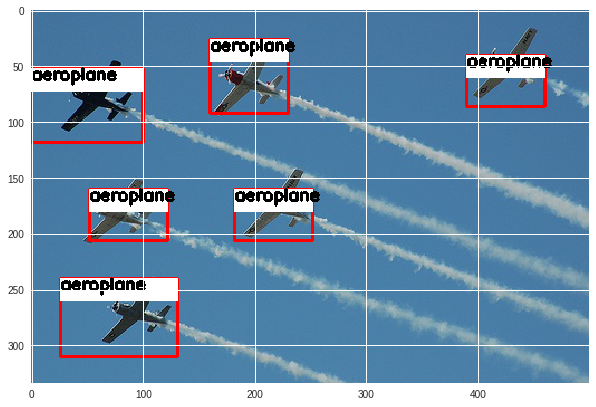

In [40]:
plot_image(sample, c_boxes, c_probs)
plt.show()

### Fucntion to get mAP using interpolation over the precision and recall curve for a single image single class predicted boxes.

In [ ]:
def get_mAP(predct_boxes, ground_boxes, probs, ratio = None):
  
  if(len(predct_boxes)==0):
    return 0
  
  ## Getting index of sort accordint to confidence
  ps = np.argsort(probs)[:len(predct_boxes)]
  
  tps = 0
  fps = 0
#   iou_ths = [0.05,0.25,0.5,0.75]  # if using multiplt thresholds...
  iou_ths = 0.5
          
  ppp = (list(predct_boxes[ps]))  
  ggg = list(ground_boxes)
  
  ### In case both are one, one
  if(len(ppp) == 1 and len(ggg) == 1):
    return (compute_iou(np.array(ppp).reshape(-1,1),np.array(ggg).reshape(-1,1))>0.5)*1
  
  ### Creating a pairwise iou matrix....
  iou_mat = np.zeros((len(ppp),len(ggg)))
  for i in range(len(ppp)):
    p_box = ppp[i]
    for j in range(len(ggg)):
      g_box = ggg[j]
      
      iou_c = compute_iou(p_box, g_box, skewed = True)
      vec = (iou_ths < iou_c)*1
      iou_mat[i,j] = np.mean(vec)
  
  vec = []
  
  ## Greedily getting the max iou regions from matrix...
  ## And eliminating pairs...
  for i in range(len(ppp)):
    ax,ay = np.unravel_index(np.argmax(iou_mat, axis=None), iou_mat.shape)
    val = iou_mat[ax,ay]
    if(val > 0.5):
      vec.append(1)
      iou_mat[ax,:] = -1*10e-64
      iou_mat[:,ay] = -1*10e-64
    else:
      vec.append(0)
  
  ### Getting the score based true false predcition vector from gredily obtained vector above...
  vec = np.array(vec)
  vec_ranked = vec[ps]
  
  ### Calculating the graph for precision recall....
  vec_prec = []
  vec_rec = []

  
  # Calculating the Precision Recall Points in Rank based oreder as above...
  n_truth = len(ggg)
  n_preds = len(ppp)
  TP = 0
  FP = 0
  for pred in vec_ranked:
    if(pred == 1):
      TP += 1
    else:
      FP += 1
    
    c_prec = TP/(TP+FP)
    c_rec = TP/n_truth
    
    vec_prec.append(c_prec)
    vec_rec.append(c_rec)
    
  vec_prec = np.array(vec_prec)
  vec_rec = np.array(vec_rec)
  
  ### Interpolating the above generated curve to find area....
  p_index = 0
  p_val = 1
  inc = 0
  for i in range(len(vec_prec)):
    c_prec = vec_prec[i]
    c_rec = vec_rec[i]
    if(c_prec < p_val):
      p_index = i
      vec_prec[p_index:i] = p_val
      p_val = c_prec
    else:
      p_val = c_prec
      
      
  ### Calculating the area of interpolated curve
  area = np.trapz(vec_prec, vec_rec)
      
      
  return area

Test the trained model on the test dataset.

### Defining the test function used to calculate dataset mAP

In [ ]:
corrects  = [] # For Plotting
wrongs = [] # For plotting
def test(two_layer = False):
  # Write loops for testing the model on the test set
  # Also print out the accuracy of the model

  t_boxes = {}
  maps_net = []
  c_maps_net = []
  path = test_path
  mAP = 0
  # Reading teh XML file....
  for xml_path in sorted(os.listdir(path + anno)):
      torch.cuda.empty_cache()
      tree = ET.parse(path + anno + "/" + xml_path)
      image = Image.open(path + jpeg + "/" + tree.getroot()[1].text)
      image_arr = np.array(image)
      Nn,Nm,nC = image_arr.shape
      img_n_obj=0
      found = False
      
      # searching for object................
      ## This part is similar to build dataset funciton given above...
      b_boxes = {}
      for class_name in classes:
        b_boxes[class_name] = []

      for obj in tree.getroot().findall('object'):
          class_name = obj[0].text
          if(class_name in classes):
              img_n_obj+=1
              xmin = int(obj[4][0].text)
              ymin = int(obj[4][1].text)
              xmax = int(obj[4][2].text)
              ymax = int(obj[4][3].text)

              b_boxes[class_name].append(np.array([ymin,ymax,xmin,xmax]))

      if(img_n_obj != 0):
        t_boxes = b_boxes
        sample = image#.resize((500,500), Image.ANTIALIAS)
        boxes, prs = sliding_window(sample, two_layer, 0.99,0.99)
        try:
          c_boxes, c_probs = non_maximum_supression(boxes, prs, 0.07)
        except:
          maps_net.append(0)
          continue

        prb = [[],[],[]]       
        c_maps = []
        for c in [1,2,3]:
          class_name = classes[c]
          prb[c-1] = b_boxes[class_name]
          t_boxs = (t_boxes[class_name])
          p_boxs = (c_boxes[c-1])

          if(len(t_boxs)!=0):
            if(len(p_boxs) == 0):
              c_maps.append(0)
            else:
              ratios = (Nn/500, Nm/500) ## Only needed if image is scaled and predicted bounding boxes on scaled image...
              b_mAP = get_mAP(p_boxs, t_boxs, c_probs[c-1], ratios) ## mAP obtained for this image for this class
              c_maps.append(b_mAP)
              found = True
              print("Class:",c,":", b_mAP)
          else:
            c_maps.append(np.nan)
        
        if(found):
          mAP = (np.nanmean(c_maps)) # the mean of all classes for given image...
          if(len(corrects)<5 or len(wrongs) < 5):
            if(mAP > 0.1):
              corrects.append([sample,c_boxes,c_probs])
            elif(mAP == 0):
              wrongs.append([sample, c_boxes, c_probs])
          else:
            if(np.min(np.nanmean(c_maps_net), axis = 0) > 0):
              return  ## Omit this line to pass if you want to run it for whole dataset instead of some...
          maps_net.append(mAP)
          c_maps_net.append(np.array(c_maps))
          clr(wait=True)
          try:
            print("The Current Image mAP : ",mAP," , and moving average of mAP", np.nanmean(maps_net), "and classwise avg mAP", np.nanmean(np.array(c_maps_net), axis = 0))
            plot_image(image, c_boxes, c_probs)
            plt.show()
          except:
            pass
        
  return np.nanmean(maps_net)

The Current Image mAP :  1.0  , and moving average of mAP 0.11684782608695653 and classwise avg mAP [0.125 0.2 0.031249999999999997]


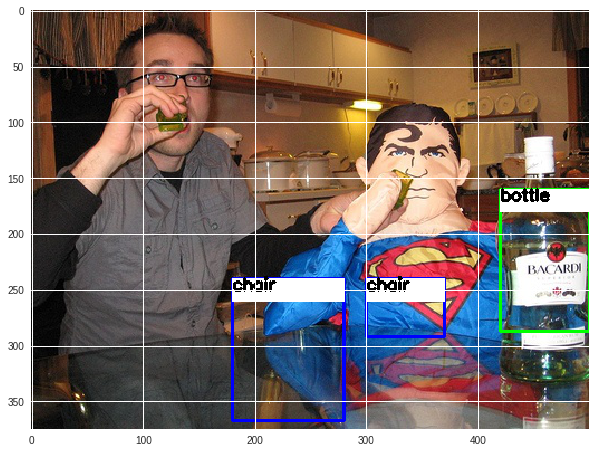

Class: 3 : 0.03125
CPU times: user 8min 18s, sys: 2min 22s, total: 10min 41s
Wall time: 10min 36s


In [105]:
#One Layer Detection
%time c_maps_net = test(two_layer = False)

Plots ::  10 Plots for  each Single layer detection....

The Corrrect Predictions


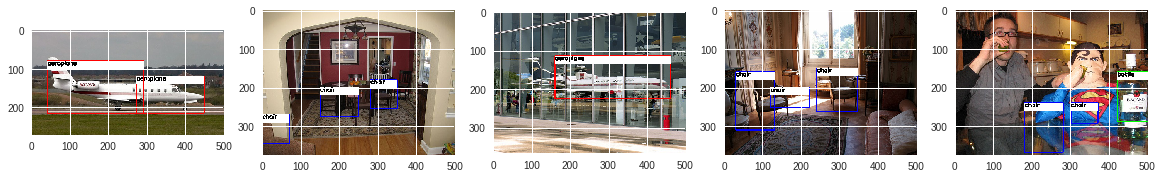

The Wrong Predictions


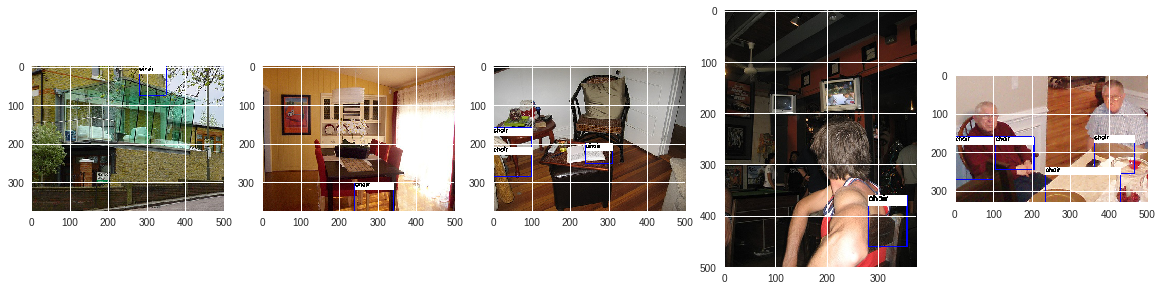

In [107]:
# Single Layer
fig, ax = plt.subplots(1,5, figsize = [20,8])
print("The Corrrect Predictions")
i=0
for part in corrects[:5]:
  sample, c_boxes, c_probs = part
  plot_image(sample, c_boxes, c_probs, ax[i])
  i+=1
plt.savefig("correct01.png")
plt.show()
fig, ax = plt.subplots(1,5, figsize = [20,8])
print("The Wrong Predictions")
i=0
for part in wrongs[:5]:
  sample, c_boxes, c_probs = part
  plot_image(sample, c_boxes, c_probs, ax[i])
  i+=1
plt.savefig("wrong01.png")
plt.show()

The Current Image mAP :  0.25  , and moving average of mAP 0.12015306122448979 and classwise avg mAP [0.20833333     0.11035412 0.04712302]


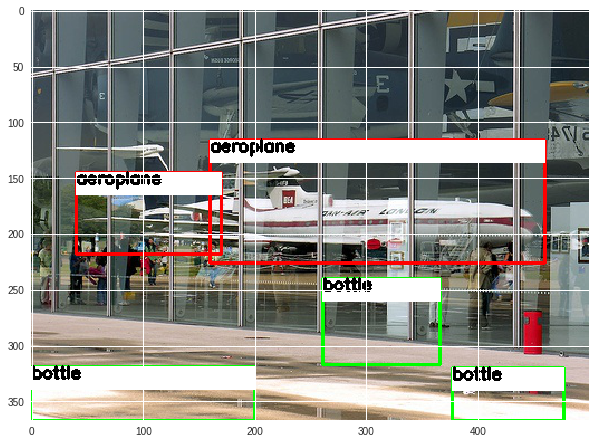

Class: 2 : 0
CPU times: user 6min 13s, sys: 2min 10s, total: 8min 23s
Wall time: 8min 21s


In [85]:
#Two Layer Detection
corrects  = []
wrongs = []
%time test(two_layer = True)

Plots ::  10 Plots for  each Two layer detection....

The Corrrect Predictions


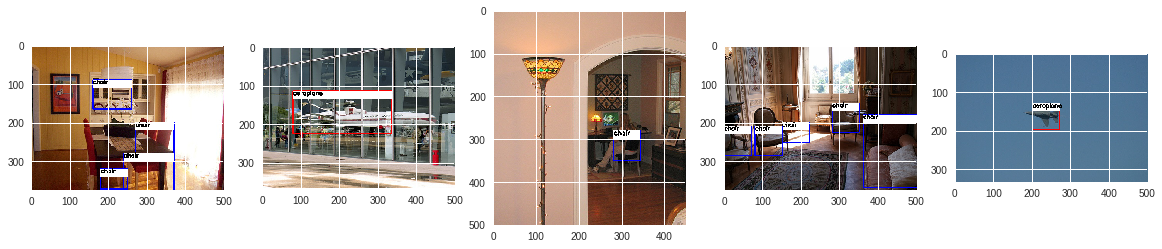

The Wrong Predictions


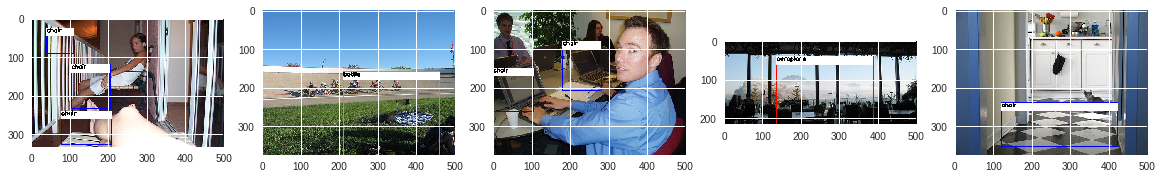

In [205]:
# Single Layer
fig, ax = plt.subplots(1,5, figsize = [20,8])
print("The Corrrect Predictions")
i=0
for part in corrects[:5]:
  sample, c_boxes, c_probs = part
  plot_image(sample, c_boxes, c_probs, ax[i])
  i+=1
plt.show()
fig, ax = plt.subplots(1,5, figsize = [20,8])
print("The Wrong Predictions")
i=0
for part in wrongs[3:8]:
  sample, c_boxes, c_probs = part
  plot_image(sample, c_boxes, c_probs, ax[i])
  i+=1

### Thankyou 

ABHISHEK KUMAR    : 18111002

HEMANTH PARIHAR : 18111021